In [1]:
from utils.utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Epidemics

### GKAN

In [2]:
model_path = './saved_models_optuna/model-epidemics-gkan/epidemics-ic3-last/1/gkan'

In [8]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_black_box = fit_black_box_from_kan(
    model_path=model_path,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    theta=-np.inf,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [9]:
symb_model_black_box

\sum_{j}( x_j*(0.50012505 - 0.5002359*x_i)) - 0.500021000882037*x_i

In [10]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_spline_wise = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path,
    theta=0.1,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

Pruning node (0,0)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib

In [11]:
symb_model_spline_wise

\sum_{j}( -0.0269925850493294*x_j + (-tanh(x_i)**3 + 0.54257786*tanh(x_j - 0.18107511) + 0.19963905)**2 - 0.22901842*sin(x_i - 1.8392199) - 0.192606347909981) - log(log(0.116798653962998*(x_i + 0.980982437994127)**3 + 1) + 1) - 0.18769063 - 0.111655645/(-0.096539944*log(x_i) - 0.5858811)

### MLP-based baseline

In [ ]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/epidemics-new-data/1'

In [ ]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    random_state = 0,
    deterministic=True,
    parallelism='serial',
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [ ]:
mpnn_symb

\sum_{j}( x_i*(0.49942818 - 0.49865368*x_j)) - 0.5019439*x_i

## Kuramoto

### GKAN

In [2]:
model_path = 'saved_models_optuna/model-kuramoto-gkan/kuramoto-ic3-last/1/gkan'

In [8]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_black_box = fit_black_box_from_kan(
    model_path=model_path,
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    theta=0.001,
    pysr_model=pysr_model,
    sample_size=8000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [9]:
symb_model_black_box

\sum_{j}( -0.4993206*sin(x_i - x_j)) - 7.2677517e-6*exp(x_i) + 2.0025613

In [3]:
pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

symb_model_spline_wise = fit_model(
    n_h_hidden_layers=2,
    n_g_hidden_layers=2,
    model_path=model_path,
    theta=0.01,
    pysr_model=pysr_model,
    sample_size=8000,
    message_passing=False
)

Pruning node (0,1)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Pruning node (0,0)
Pruning node (0,1)


In [4]:
symb_model_spline_wise

\sum_{j}( 0.3271088*sin(1.2357323*x_i - 1.3089586*x_j + 3.2265232))

## Test Experiments

In [2]:
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Kuramoto

In [4]:
optuna.delete_study(study_name="model-kuramoto-gkan-test-new-dataset", storage=storage)

In [4]:
config_path = './configs/config_kuramoto.yml'
config = load_config(config_path)
config['epochs'] = 10


exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-new-dataset',
    process_id=0,
    store_to_sqlite = False
)



In [5]:
exp.run()

[I 2025-04-16 22:20:54,803] A new study created in Journal with name: model-kuramoto-gkan-test-new-dataset
[I 2025-04-16 22:21:35,284] Trial 0 finished with value: 0.0011665469501167536 and parameters: {'lr': 0.013373430890941078, 'lamb': 1.0, 'batch_size': 32, 'use_orig_reg': False, 'lamb_g_net': 5.096932468900401e-05, 'lamb_h_net': 0.00016521859134792, 'grid_size_g_net': 5, 'spline_order_g_net': 2, 'range_limit_g_net': 10, 'mu_1_g_net': 0.8, 'mu_2_g_net': 0.9, 'hidden_dim_g_net': 2, 'grid_size_h_net': 9, 'spline_order_h_net': 2, 'range_limit_h_net': 10, 'mu_1_h_net': 1.0, 'mu_2_h_net': 0.6, 'hidden_dim_h_net': 2}. Best is trial 0 with value: 0.0011665469501167536.


### Test traffic data

In [3]:
from train_and_eval import fit, eval_model

In [ ]:
optuna.delete_study(study_name="model-metrla-mpnn-test-new-dataset", storage=storage)

In [5]:
config_path = './configs/config_metrla_mpnn.yml'
config = load_config(config_path)
# config['epochs'] = 10
# config['name'] = 'metrla2'
# config['n_iter'] = 5
# config['method'] = 'dopri5'
# config['num_samples'] = 96
# config['include_time'] = True
# config['message_passing'] = True
# config['adjoint'] = True
# config['horizon'] = 36
# config['atol'] = 0.00001
# config['rtol'] = 0.001
# config['device'] = 'cuda'

In [8]:
exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-new-dataset',
    process_id=0,
    store_to_sqlite = False,
    save_cache_data = False
)

In [9]:
exp.epochs = 10
exp.run()

[I 2025-05-04 11:07:39,573] Using an existing study with name 'model-metrla-mpnn-test-new-dataset' instead of creating a new one.


Epoch: 0 	 Training loss: 0.14666 	 Val Loss: 0.14806 	 Tot Loss: 0.14666
Epoch: 1 	 Training loss: 0.13684 	 Val Loss: 0.14671 	 Tot Loss: 0.13684
Epoch: 2 	 Training loss: 0.13511 	 Val Loss: 0.14569 	 Tot Loss: 0.13511
Epoch: 3 	 Training loss: 0.13281 	 Val Loss: 0.14382 	 Tot Loss: 0.13281
Epoch: 4 	 Training loss: 0.13611 	 Val Loss: 0.14226 	 Tot Loss: 0.13611
Epoch: 5 	 Training loss: 0.13219 	 Val Loss: 0.14071 	 Tot Loss: 0.13219
Epoch: 6 	 Training loss: 0.13528 	 Val Loss: 0.13949 	 Tot Loss: 0.13528
Epoch: 7 	 Training loss: 0.13082 	 Val Loss: 0.13959 	 Tot Loss: 0.13082
Epoch: 8 	 Training loss: 0.12987 	 Val Loss: 0.13792 	 Tot Loss: 0.12987
Epoch: 9 	 Training loss: 0.13068 	 Val Loss: 0.13740 	 Tot Loss: 0.13068

Loading best model found at epoch 9 with val loss 0.13740234076976776
Test loss: 5.658344268798828


[I 2025-05-04 11:08:07,503] Trial 1 finished with value: 0.13740234076976776 and parameters: {'lr': 0.01609819051114998, 'lamb': 0.0, 'batch_size': 16, 'n_hidden_layers_g_net': 1, 'hidden_dims_g_net': 64, 'af_g_net': 'tanh', 'drop_p_g_net': 0.0001, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 64, 'af_h_net': 'tanh', 'drop_p_h_net': 0.0001}. Best is trial 1 with value: 0.13740234076976776.


## Data visualization METR-LA

In [6]:
import json
import matplotlib.pyplot as plt
from models.utils.MPNN import MPNN
from models.kan.KAN import KAN
from models.GKAN_ODE import GKAN_ODE
from models.utils.ODEBlock import ODEBlock
import torch


In [10]:
training_set, valid_set, test_set = exp.training_set, exp.valid_set, exp.test_set

In [11]:
scaler = exp.pre_processing(training_set)

In [12]:
from models.baseline.baseline import LB_ODE

LB_base = LB_ODE(model_path='./saved_models_optuna/tmp-lb')

eval_model(
    model=LB_base,
    valid_data=test_set,
    criterion=exp.criterion,
    scaler=scaler
)

6.13160514831543

In [13]:
eval_model(
    model=LB_base,
    valid_data=valid_set,
    criterion=exp.criterion,
    scaler=scaler,
    inverse_scale=False
)

0.14844045042991638

### Utils

In [11]:
def plot_results(losses, label, title):
    epochs = range(len(losses))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses, label=label, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [28]:
from types import SimpleNamespace

def get_predictions(model:ODEBlock, data, time, scaler, edge_index, edge_attr):
    model.eval()
    x = data[0] if scaler is None else scaler.transform(data[0])
    
    with torch.no_grad():
        fake_snap = SimpleNamespace(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            t_span=time
        )
    
        y_pred = model(snapshot = fake_snap)    # (96, 207, 1)

    y_true = data if scaler is None else scaler.transform(data)
    
    return y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
    

def plot_predictions(y_true, y_pred, node_index = 0):
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [14]:
def build_model_from_file(best_params_file, best_state_path, message_passing, include_time, method='midpoint', adjoint=False):
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    # g_net
    g_net = KAN(
        layers_hidden=[1, best_hyperparams['hidden_dim_g_net'], 1],
        grid_size=best_hyperparams['grid_size_g_net'],
        spline_order=best_hyperparams['spline_order_g_net'],
        grid_range=[-best_hyperparams['range_limit_g_net'], best_hyperparams['range_limit_g_net']],
        mu_1=best_hyperparams['mu_1_g_net'],
        mu_2=best_hyperparams['mu_2_g_net'],
        device='cuda'
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    
    # h_net
    h_net = KAN(
        layers_hidden=[in_dim_h, best_hyperparams['hidden_dim_h_net'], 1],
        grid_size=best_hyperparams['grid_size_h_net'],
        spline_order=best_hyperparams['spline_order_h_net'],
        grid_range=[-best_hyperparams['range_limit_h_net'], best_hyperparams['range_limit_h_net']],
        mu_1=best_hyperparams['mu_1_h_net'],
        mu_2=best_hyperparams['mu_2_h_net'],
        device='cuda'
    )
    
    gkan = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = GKAN_ODE(
        conv=gkan,
        model_path='./saved_models_optuna/tmp',
        lmbd_g=best_hyperparams['lamb_g_net'],
        lmbd_h=best_hyperparams['lamb_h_net'],
        integration_method=method,
        adjoint=adjoint
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False))
    
    return model
    
    
    
    

### GKAN-ODE

In [15]:
model_path_metrla = './saved_models_optuna/model-metrla-gkan/metrla-ic-all-time-h18-ep50/0/gkan'

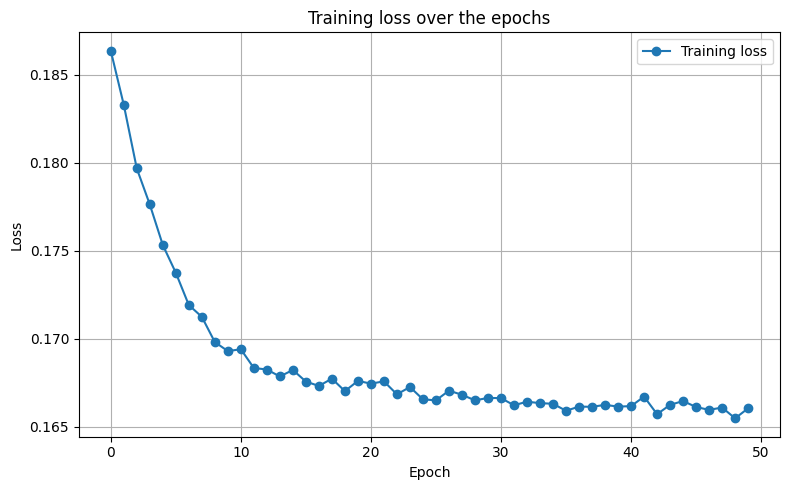

In [16]:
with open(f'{model_path_metrla}/results.json', 'r') as f:
    results = json.load(f)

plot_results(
    results['train_loss'],
    label = 'Training loss',
    title = 'Training loss over the epochs'
)

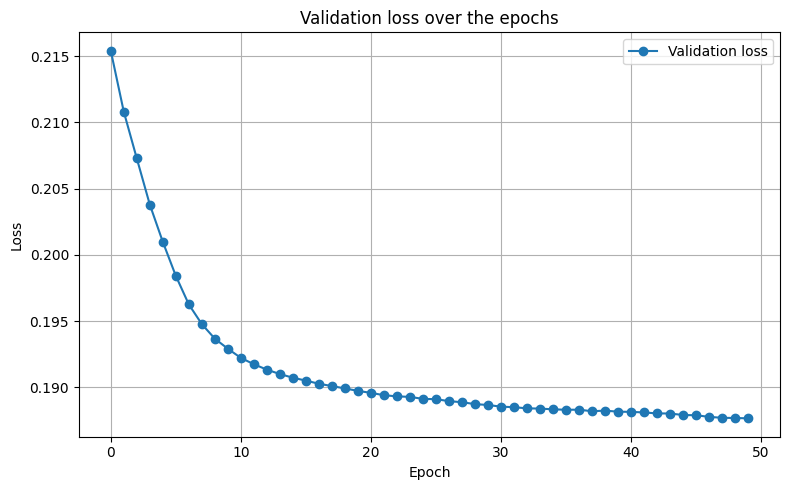

In [17]:
plot_results(
    results['validation_loss'],
    label = 'Validation loss',
    title = 'Validation loss over the epochs'
)

In [18]:
best_model = build_model_from_file(
    best_params_file='./saved_models_optuna/model-metrla-gkan/metrla-ic-all-time-h18-ep50/0/best_params.json',
    best_state_path='./saved_models_optuna/model-metrla-gkan/metrla-ic-all-time-h18-ep50/0/gkan/state_dict.pth',
    message_passing=True,
    include_time=True,
    method='dopri5',
    adjoint=True
)

In [19]:
raw_data, raw_time = training_set.raw_data_sampled, training_set.t_sampled

In [20]:
best_model = best_model.to(torch.device('cuda'))

In [29]:
y_true, y_pred = get_predictions(
    model=best_model,
    data=raw_data[0][:288],   # first day
    time=raw_time[0][:288],   # first day
    scaler=scaler,
    edge_index=training_set[0].edge_index,
    edge_attr=training_set[0].edge_attr
)

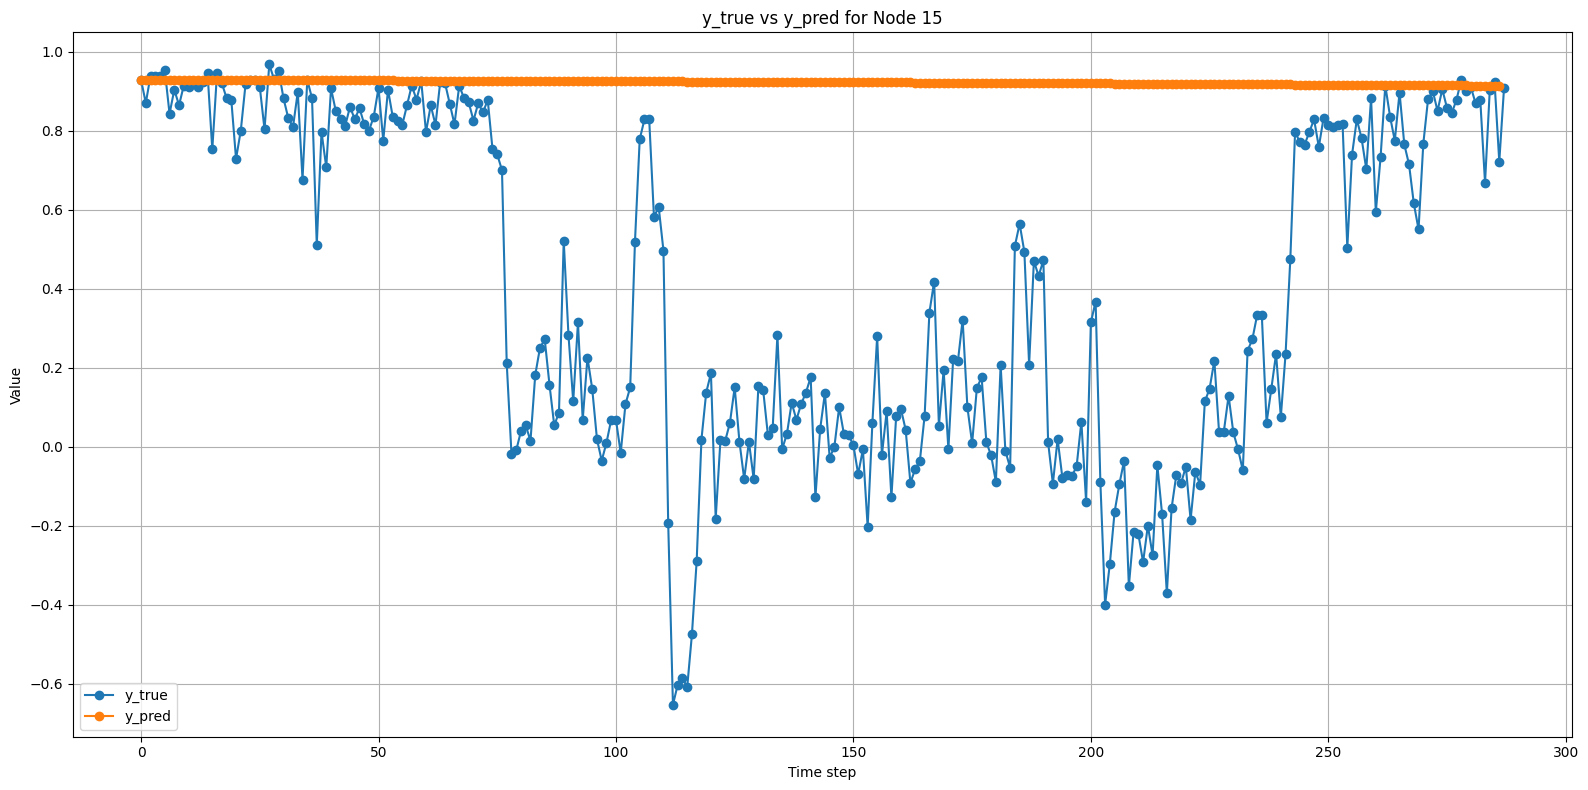

In [30]:
node_index = 15
plot_predictions(y_true=y_true, y_pred=y_pred, node_index=node_index)

### TG-ODE

In [20]:
from models.baseline.baseline import TG_ODE

In [21]:
best_tgode_path = 'saved_models_optuna/model-metrla-tg-ode/metrla-all/2/tgode'

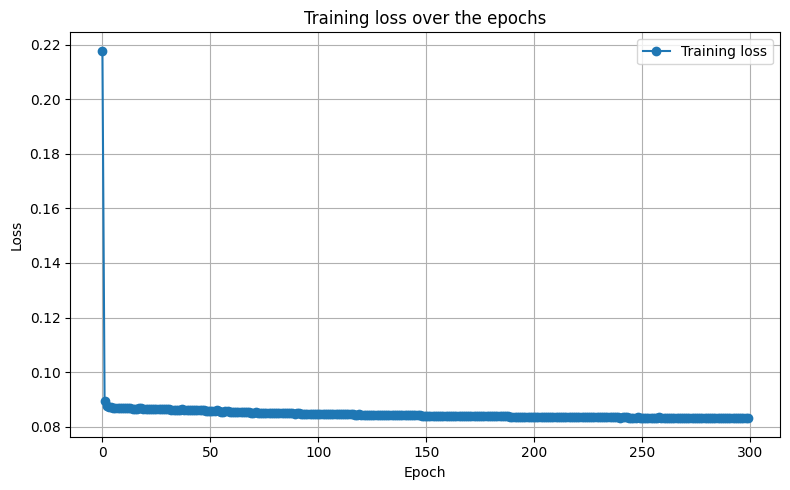

In [22]:
with open(f'{best_tgode_path}/results.json', 'r') as f:
    results = json.load(f)

plot_results(
    results['train_loss'],
    label = 'Training loss',
    title = 'Training loss over the epochs'
)

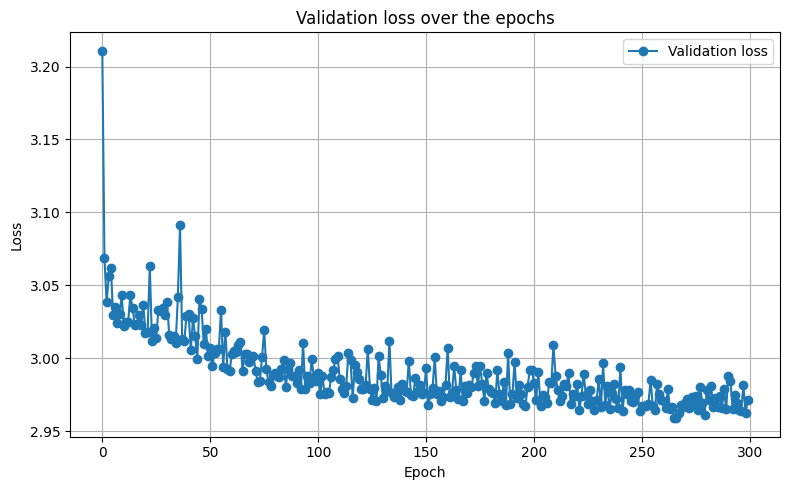

In [23]:
plot_results(
    results['validation_loss'],
    label = 'Validation loss',
    title = 'Validation loss over the epochs'
)

In [24]:
from experiments.experiments_mpnn import activations

In [25]:
best_model_tgode = TG_ODE(
    model_path = './saved_models_optuna/tgode-tmp',
    in_dim = 1,
    emb_dim = 64,
    K = 3,
    af = activations['relu'],
    step_size = 0.7819801453386249,
    normalize = True,
    bias = False
)

In [26]:
best_model_tgode.load_state_dict(torch.load(f'{best_tgode_path}/state_dict.pth', weights_only=False))

<All keys matched successfully>

In [27]:
best_model_tgode = best_model_tgode.to(torch.device('cuda'))

In [28]:
eval_model(
    best_model_tgode,
    test_set,
    torch.nn.L1Loss(),
    scaler=scaler
)

2.7811293601989746

In [41]:
y_true, y_pred = get_predictions(best_model_tgode, valid_set, scaler)

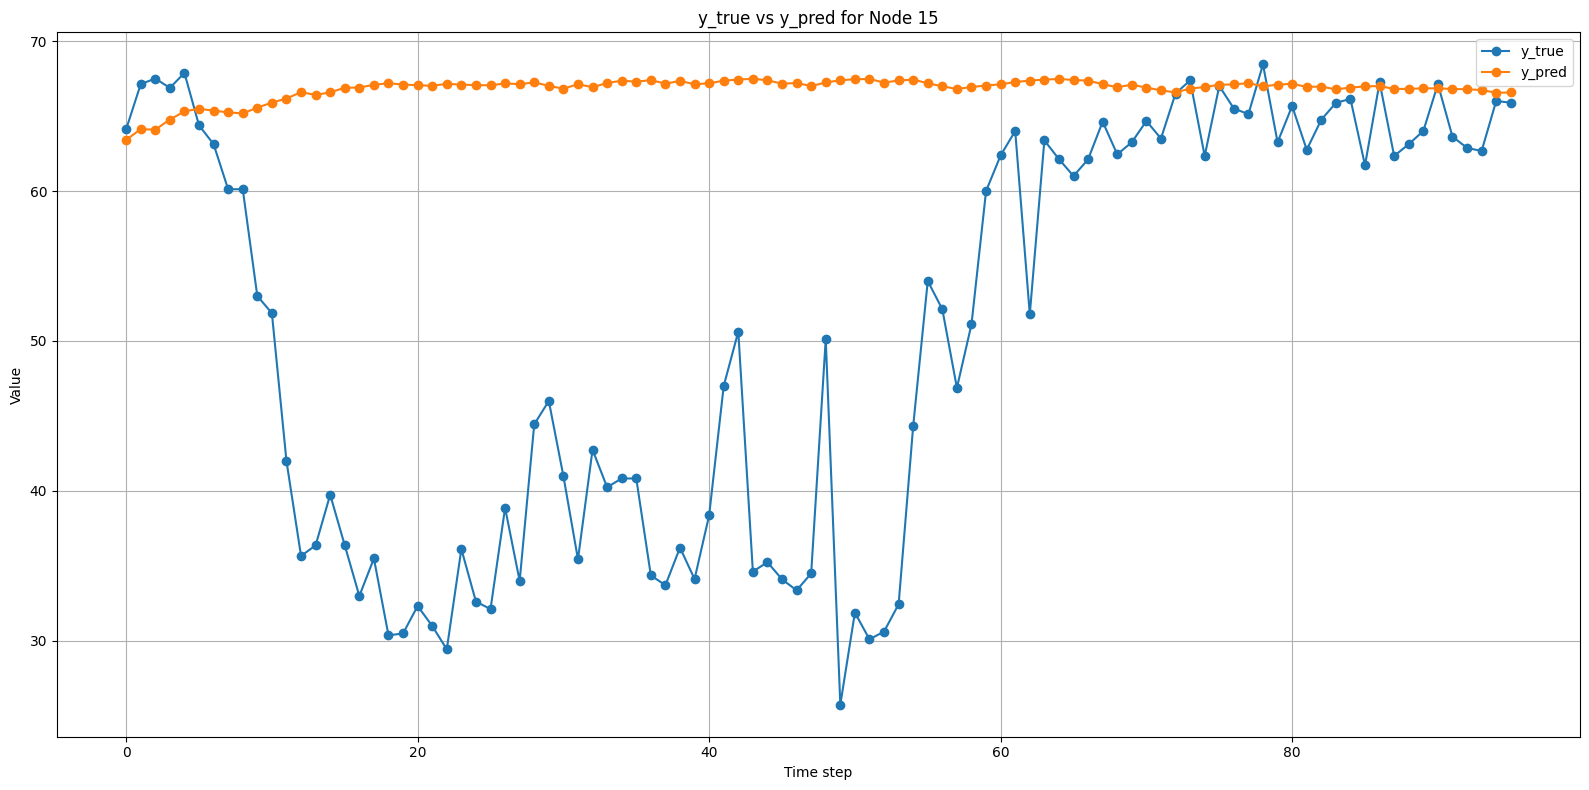

In [42]:
plot_predictions(y_true=y_true, y_pred=y_pred, node_index=15)